In [7]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets,transforms
from tqdm import tqdm
import cv2
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import os
import torch.nn.functional as F

In [8]:
#在Python宣告時加入 解決 An error ocurred while starting the kernel
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# config
LEARNING_RATE = 1e-4
SPLIT=0.2
DEVICE = "cpu" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4
EPOCHS = 4
NUM_WORKERS = 4
IMAGE_HEIGHT = 572
IMAGE_WIDTH = 572
PIN_MEMORY = True
#DATAPATH = r"D:\研究所\Deep Learning\WEEK14\data\data"
TRAIN_IMG_DIR =r'C:\Users\User\Desktop\WEEK14\CAR'
TRAIN_MASK_DIR =r'C:\Users\User\Desktop\WEEK14\CAR_MASK'

In [9]:
import torch
import torch.nn as nn


def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )
    return conv.to(DEVICE)


# def crop_img(tensor, target_tensor):
#     target_size = target_tensor.size()[2]
#     tensor_size = tensor.size()[2]
#     delta = tensor_size-target_size
#     delta = delta//2
#     # all batch, all channels, heightModified,widthModified

#     return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]

def addPadding(srcShapeTensor, tensor_whose_shape_isTobechanged):

    if(srcShapeTensor.shape != tensor_whose_shape_isTobechanged.shape):
        target = torch.zeros(srcShapeTensor.shape)
        target[:, :, :tensor_whose_shape_isTobechanged.shape[2],
               :tensor_whose_shape_isTobechanged.shape[3]] = tensor_whose_shape_isTobechanged
        return target.to(DEVICE)
    return tensor_whose_shape_isTobechanged.to(DEVICE)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(3, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)

        self.up_trans_1 = nn.ConvTranspose2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=2,
            stride=2
        )
        self.up_conv_1 = double_conv(1024, 512)

        self.up_trans_2 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=2,
            stride=2
        )
        self.up_conv_2 = double_conv(512, 256)

        self.up_trans_3 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=2,
            stride=2
        )
        self.up_conv_3 = double_conv(256, 128)

        self.up_trans_4 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=2,
            stride=2
        )
        self.up_conv_4 = double_conv(128, 64)

        self.out = nn.Conv2d(
            in_channels=64,
            out_channels=1,
            kernel_size=1
        )

    def forward(self, image):
        # expected size
        # encoder (Normal convolutions decrease the size)
        x1 = self.down_conv_1(image)
        # print("x1 "+str(x1.shape))
        x2 = self.max_pool_2x2(x1)
        # print("x2 "+str(x2.shape))
        x3 = self.down_conv_2(x2)
        # print("x3 "+str(x3.shape))
        x4 = self.max_pool_2x2(x3)
        # print("x4 "+str(x4.shape))
        x5 = self.down_conv_3(x4)
        # print("x5 "+str(x5.shape))
        x6 = self.max_pool_2x2(x5)
        # print("x6 "+str(x6.shape))
        x7 = self.down_conv_4(x6)
        # print("x7 "+str(x7.shape))
        x8 = self.max_pool_2x2(x7)
        # print("x8 "+str(x8.shape))
        x9 = self.down_conv_5(x8)
        # print("x9 "+str(x9.shape))

        # decoder (transposed convolutions increase the size)
        x = self.up_trans_1(x9)
        x = addPadding(x7, x)
        x = self.up_conv_1(torch.cat([x7, x], 1))

        x = self.up_trans_2(x)
        x = addPadding(x5, x)
        x = self.up_conv_2(torch.cat([x5, x], 1))

        x = self.up_trans_3(x)
        x = addPadding(x3, x)
        x = self.up_conv_3(torch.cat([x3, x], 1))

        x = self.up_trans_4(x)
        x = addPadding(x1, x)
        x = self.up_conv_4(torch.cat([x1, x], 1))

        x = self.out(x)
        # print(x.shape)
        return x.to(DEVICE)


# if __name__ == "__main__":
#     image = torch.rand((3, 3, 572, 572))
#     model = UNet()
#     print(image.shape)
#     model(image)

In [10]:
class CarvanaDataset(Dataset):
    def __init__(self,images,image_dir,mask_dir,transform=None,train=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.isTrain = train
        self.images = images
    def __len__(self):
        return len(self.images)
    def __getitem__(self,index):
        img_path = os.path.join(self.image_dir,self.images[index])
        mask_path = os.path.join(self.mask_dir,self.images[index].replace(".jpg","_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"),dtype=np.float32)
        mask[mask == 255.0] = 1.0
        
        if self.transform is not None:
            augmentations = self.transform(image=image,mask=mask)
            image = augmentations['image']
            mask = augmentations['mask']
            
        return {"image":image,"mask":mask}

In [11]:
images = os.listdir(TRAIN_IMG_DIR)
masks = os.listdir(TRAIN_MASK_DIR)

#importing the os module
import os

#to get the current working directory
directory = os.getcwd()

print(directory)

masks , images


C:\Users\User\Desktop\WEEK14


(['0cdf5b5d0ce1_01_mask.gif',
  '0cdf5b5d0ce1_02_mask.gif',
  '0cdf5b5d0ce1_03_mask.gif',
  '0cdf5b5d0ce1_04_mask.gif',
  '0cdf5b5d0ce1_05_mask.gif',
  '0cdf5b5d0ce1_06_mask.gif',
  '0cdf5b5d0ce1_07_mask.gif',
  '0cdf5b5d0ce1_08_mask.gif',
  '0cdf5b5d0ce1_09_mask.gif',
  '0cdf5b5d0ce1_10_mask.gif',
  '0cdf5b5d0ce1_11_mask.gif',
  '0cdf5b5d0ce1_12_mask.gif',
  '0cdf5b5d0ce1_13_mask.gif',
  '0cdf5b5d0ce1_14_mask.gif'],
 ['0cdf5b5d0ce1_01.jpg',
  '0cdf5b5d0ce1_02.jpg',
  '0cdf5b5d0ce1_03.jpg',
  '0cdf5b5d0ce1_04.jpg',
  '0cdf5b5d0ce1_05.jpg',
  '0cdf5b5d0ce1_06.jpg',
  '0cdf5b5d0ce1_07.jpg',
  '0cdf5b5d0ce1_08.jpg',
  '0cdf5b5d0ce1_09.jpg',
  '0cdf5b5d0ce1_10.jpg',
  '0cdf5b5d0ce1_11.jpg',
  '0cdf5b5d0ce1_12.jpg',
  '0cdf5b5d0ce1_13.jpg',
  '0cdf5b5d0ce1_14.jpg'])

(1280, 1918, 3)


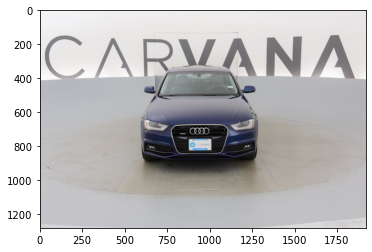

In [12]:
import numpy as np

img = np.array(Image.open(TRAIN_IMG_DIR+"/"+images[0]).convert("RGB"))
plt.imshow(img,cmap="gray")
print(img.shape)

(1280, 1918)


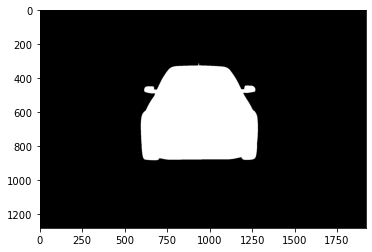

In [13]:
msk = np.array(Image.open(TRAIN_MASK_DIR+"/"+images[0].replace(".jpg","_mask.gif")).convert("L"))
plt.imshow(msk,cmap="gray")
print(msk.shape)

In [14]:
def fit(model,dataloader,data,optimizer,criterion):
    print('-------------Training---------------')
    model.train()
    train_running_loss = 0.0
    counter=0
    
    # num of batches
    num_batches = int(len(data)/dataloader.batch_size)
    for i,data in tqdm(enumerate(dataloader),total=num_batches):
        counter+=1
        image,mask = data["image"].to(DEVICE),data["mask"].to(DEVICE)
        optimizer.zero_grad()
        outputs = model(image)
        outputs =outputs.squeeze(1)
        loss = criterion(outputs,mask)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/counter
    return train_loss
def validate(model,dataloader,data,criterion):
    print("\n--------Validating---------\n")
    model.eval()
    valid_running_loss = 0.0
    counter = 0
    # number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    with torch.no_grad():
        for i,data in tqdm(enumerate(dataloader),total=num_batches):
            counter+=1
            image,mask = data["image"].to(DEVICE),data["mask"].to(DEVICE)
            outputs = model(image)
            outputs =outputs.squeeze(1)
            loss = criterion(outputs,mask)
            valid_running_loss += loss.item()
    valid_loss = valid_running_loss/counter
    return valid_loss
    

In [15]:
import albumentations as A
from albumentations.pytorch import ToTensorV2 

In [16]:
train_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT,IMAGE_WIDTH),
    A.Rotate(limit=35,p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(
        mean=[0.0,0.0,0.0],
        std = [1.0,1.0,1.0],
        max_pixel_value=255.0
    ),
    ToTensorV2()  
])
validation_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT,IMAGE_WIDTH),
    A.Normalize(
        mean = [0.0,0.0,0.0],
        std = [1.0,1.0,1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2()
])

In [17]:
def train_test_split(images,splitSize):
    imageLen = len(images)
    val_len = int(splitSize*imageLen)
    train_len = imageLen - val_len
    train_images,val_images = images[:train_len],images[train_len:]
    return train_images,val_images

In [18]:
train_images_path,val_images_path = train_test_split(images,SPLIT)
train_data = CarvanaDataset(train_images_path,TRAIN_IMG_DIR,TRAIN_MASK_DIR,train_transform,True)
valid_data = CarvanaDataset(val_images_path,TRAIN_IMG_DIR,TRAIN_MASK_DIR,validation_transform,True)
train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
valid_dataloader = DataLoader(valid_data,batch_size=BATCH_SIZE,shuffle=False)

Epoch 1 of 4
-------------Training---------------


100%|██████████| 3/3 [01:34<00:00, 31.58s/it]



--------Validating---------



1it [00:04,  4.97s/it]


Train Loss: 0.6855
Val Loss: 0.7058
Epoch 2 of 4
-------------Training---------------


100%|██████████| 3/3 [01:34<00:00, 31.60s/it]



--------Validating---------



1it [00:04,  4.98s/it]


Train Loss: 0.5404
Val Loss: 0.6921
Epoch 3 of 4
-------------Training---------------


100%|██████████| 3/3 [01:34<00:00, 31.65s/it]



--------Validating---------



1it [00:05,  5.20s/it]


Train Loss: 0.4627
Val Loss: 0.6728
Epoch 4 of 4
-------------Training---------------


100%|██████████| 3/3 [01:37<00:00, 32.45s/it]



--------Validating---------



1it [00:05,  5.61s/it]

Train Loss: 0.4070
Val Loss: 0.6466


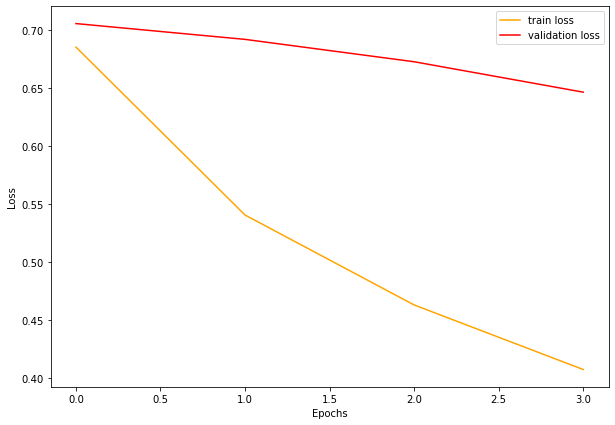


---------DONE TRAINING----------



In [19]:
train_loss = []
val_loss =[]
model = UNet().to(DEVICE)
optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = fit(model, train_dataloader, train_data,optimizer,criterion)
    val_epoch_loss = validate(model, valid_dataloader, valid_data, criterion)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color="orange", label='train loss')
plt.plot(val_loss, color="red", label='validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
# plt.savefig(f"../input/loss.png")
plt.show()
torch.save({
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': criterion,
}, "./model.pth")

print("\n---------DONE TRAINING----------\n")

In [20]:
data = train_data.__getitem__(100)
plt.imshow(data['mask'],cmap="gray")
print(train_data.__getitem__(0)['mask'].shape)

IndexError: list index out of range

In [ ]:
# for Testing on Single datapoint after training
# plt.imshow(np.transpose(np.array(data['image']),(1,2,0)),cmap="gray")
print(data['image'].shape)
img = data['image'].unsqueeze(0).to(device="cuda")
# model = UNet()
output = model(img)
output = torch.squeeze(output)
output[output>0.0] = 1.0
output[output<=0.0]=0
print(torch.max(output))
print(output.shape)
disp = output.detach().cpu()
plt.imshow(disp,cmap="gray")